In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [69]:
INPUT_CATALINA = "raw/raw_processes_catalina.log.gz"
INPUT_MONTEREY = "raw/raw_processes_monterey.log.gz"
OUTPUT_PROC = "intermediate/processes.csv.gz"
OUTPUT_STAT = "intermediate/stats.csv.gz"

In [75]:
def read_file(path):
    df = (pd.read_table(path, header=None, index_col=False, sep="\t", engine="python")
            .rename(columns={0:"data"})
         )
    return df
df = read_file("test.log")
df.head()

,data,1,2
0,%%%,2023-01-25 00:17:26-0300,processes
1,USER PID %CPU %MEM VSZ ...,None,None
2,diegocaro 1074 6.7 1.1 34816524 189...,None,None
3,_windowserver 173 3.4 0.9 37202048 153...,None,None
4,diegocaro 956 1.1 0.9 35005616 149...,None,None


In [13]:
def get_raw_dataframes(frame):
    sections = list(frame[frame["data"]=="%%%"].index) + [len(frame)]
    limits = list(zip(sections, sections[1:]))
    
    processes_frame = [frame.iloc[start:end] for start, end  in limits[0::2]]
    stats_frame = [frame.iloc[start:end] for start, end  in limits[1::2]]
    
    assert len(processes_frame) == len(stats_frame)
    
    return processes_frame, stats_frame

processes, stats = get_raw_dataframes(df)
processes, stats

([                                                  data  \
  0                                                  %%%   
  1    USER               PID  %CPU %MEM      VSZ    ...   
  2    diegocaro         1074   6.7  1.1 34816524 189...   
  3    _windowserver      173   3.4  0.9 37202048 153...   
  4    diegocaro          956   1.1  0.9 35005616 149...   
  ..                                                 ...   
  457  diegocaro         8506   0.0  0.3 36117252  49...   
  458  diegocaro         8501   0.0  0.6 34258004  97...   
  459  diegocaro         6538   0.0  0.3 36135000  46...   
  460  diegocaro         6536   0.0  0.8 36216624 133...   
  461  diegocaro         6532   0.0  0.3 36146080  56...   
  
                              1          2  
  0    2023-01-25 00:17:26-0300  processes  
  1                         NaN        NaN  
  2                         NaN        NaN  
  3                         NaN        NaN  
  4                         NaN        NaN  
  ..   

In [14]:
def get_headers(frame):
    datetime = pd.to_datetime(frame[1].iloc[0])
    process = frame[2].iloc[0]
    return datetime, process

datetime, process_name = get_headers(processes[0])
datetime, process_name

(Timestamp('2023-01-25 00:17:26-0300', tz='pytz.FixedOffset(-180)'),
 'processes')

In [53]:
def clean_process(frame):
    numeric_cols = ["pid","cpu", "mem"]
    columns_type = {col:float for col in numeric_cols}
    
    datetime, process = get_headers(frame)
    raw_lines = frame.iloc[1:].data.str.split(expand=True, n=10)
    
    header = raw_lines.iloc[0]
    columns = {index:column.strip("% \t").lower() for index, column in enumerate(header)}
    
    out_frame = (raw_lines.iloc[1:]
                .rename(columns=columns)
                .assign(date=datetime)
                .assign(process=process)
                .astype(dtype=columns_type)
                .reset_index(drop=True)
           )
    return out_frame
data = clean_process(processes[0])
data.head()

,user,pid,cpu,mem,vsz,rss,tt,stat,started,time,command,date,process
0,diegocaro,1074.0,6.7,1.1,34816524,189716,??,R,8:10PM,2:08.77,/Applications/iTerm.app/Contents/MacOS/iTerm2,2023-01-25 00:17:26-03:00,processes
1,_windowserver,173.0,3.4,0.9,37202048,153772,??,Ss,8:58AM,16:44.33,/System/Library/PrivateFrameworks/SkyLight.fra...,2023-01-25 00:17:26-03:00,processes
2,diegocaro,956.0,1.1,0.9,35005616,149500,??,S,7:42PM,2:04.49,/System/Applications/Messages.app/Contents/Mac...,2023-01-25 00:17:26-03:00,processes
3,diegocaro,8644.0,0.9,0.0,34124420,1288,s001,S+,12:17AM,0:00.00,bash 02_processes.sh,2023-01-25 00:17:26-03:00,processes
4,diegocaro,506.0,0.7,3.8,74825608,642828,??,S,8:58AM,3:30.59,/Applications/Dropbox.app/Contents/MacOS/Dropbox,2023-01-25 00:17:26-03:00,processes


In [51]:
def clean_stats(frame):
    datetime, process = get_headers(frame)
    raw_lines = (frame.data.str.split(":",expand=True)
                   .rename(columns={0:"keys", 1: "values"})
                )

    data_rows = (~raw_lines["keys"].str.startswith("---")) & (raw_lines["values"].notnull())
    key_values = (raw_lines[data_rows]
                  .assign(values=lambda df: df["values"].str.extract("([\d\.]+)")) # extract data from values
                  .dropna().set_index("keys")
                  .T.astype(float)    # transpose and assign datatype
                 )

    columns = {column:column.strip().replace(" ", "_").lower() for column in key_values.columns}
    out_frame = (key_values.rename(columns=columns)
                           .assign(date=datetime)
                           .assign(process=process)
                           .reset_index(drop=True)
    )
    return out_frame
data = clean_stats(stats[0])
data

keys,cpu_temp,total_fans_in_system,fan_0_speed,fan_1_speed,cycle_count,max_cycles,current_charge,maximum_charge,design_capacity,battery_temp,date,process
0,38.88,2.0,1838.0,1705.0,182.0,1000.0,4029.0,7841.0,8790.0,32.5,2023-01-25 00:17:26-03:00,istats


In [30]:
process_df = pd.concat(clean_process(frame) for frame in processes)
process_df

,user,pid,cpu,mem,vsz,rss,tt,stat,started,time,command,date,process
2,diegocaro,1074.0,6.7,1.1,34816524,189716,??,R,8:10PM,2:08.77,/Applications/iTerm.app/Contents/MacOS/iTerm2,2023-01-25 00:17:26-03:00,processes
3,_windowserver,173.0,3.4,0.9,37202048,153772,??,Ss,8:58AM,16:44.33,/System/Library/PrivateFrameworks/SkyLight.fra...,2023-01-25 00:17:26-03:00,processes
4,diegocaro,956.0,1.1,0.9,35005616,149500,??,S,7:42PM,2:04.49,/System/Applications/Messages.app/Contents/Mac...,2023-01-25 00:17:26-03:00,processes
5,diegocaro,8644.0,0.9,0.0,34124420,1288,s001,S+,12:17AM,0:00.00,bash 02_processes.sh,2023-01-25 00:17:26-03:00,processes
6,diegocaro,506.0,0.7,3.8,74825608,642828,??,S,8:58AM,3:30.59,/Applications/Dropbox.app/Contents/MacOS/Dropbox,2023-01-25 00:17:26-03:00,processes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,diegocaro,8507.0,0.0,0.3,36115544,46872,??,S,12:03AM,0:00.15,/Applications/Firefox.app/Contents/MacOS/plugi...,2023-01-25 00:17:32-03:00,processes
2848,diegocaro,8506.0,0.0,0.3,36117252,49352,??,S,12:03AM,0:00.19,/Applications/Firefox.app/Contents/MacOS/plugi...,2023-01-25 00:17:32-03:00,processes
2849,diegocaro,6538.0,0.0,0.3,36135000,46876,??,S,11:46PM,0:00.17,/Applications/Firefox.app/Contents/MacOS/plugi...,2023-01-25 00:17:32-03:00,processes
2850,diegocaro,6532.0,0.0,0.3,36146080,56324,??,S,11:46PM,0:00.76,/Applications/Firefox.app/Contents/MacOS/plugi...,2023-01-25 00:17:32-03:00,processes


In [31]:
stats_df = pd.concat(clean_stats(frame) for frame in stats)
stats_df

,cpu_temp,total_fans_in_system,fan_0_speed,fan_1_speed,cycle_count,max_cycles,current_charge,maximum_charge,design_capacity,battery_temp,date,process
0,38.88,2.0,1838.0,1705.0,182.0,1000.0,4029.0,7841.0,8790.0,32.5,2023-01-25 00:17:26-03:00,istats
0,38.81,2.0,1825.0,1698.0,182.0,1000.0,4029.0,7841.0,8790.0,32.5,2023-01-25 00:17:27-03:00,istats
0,40.31,2.0,1849.0,1696.0,182.0,1000.0,4029.0,7841.0,8790.0,32.5,2023-01-25 00:17:29-03:00,istats
0,40.38,2.0,1824.0,1697.0,182.0,1000.0,4029.0,7841.0,8790.0,32.5,2023-01-25 00:17:30-03:00,istats
0,39.56,2.0,1838.0,1704.0,182.0,1000.0,4029.0,7841.0,8790.0,32.5,2023-01-25 00:17:31-03:00,istats
0,39.63,2.0,1835.0,1696.0,182.0,1000.0,4029.0,7841.0,8790.0,32.5,2023-01-25 00:17:32-03:00,istats


In [33]:
def clean(raw_frame):
    processes, stats = get_raw_dataframes(raw_frame)
    processes_df = (pd.concat(clean_process(frame) for frame in processes).reset_index(drop=True)
                      .assign(delta_time = lambda df: df['date'] - df['date'].min())
                      .assign(delta = lambda df: df['delta_time']/pd.Timedelta('1m'))
                   )
            
    stats_df = (pd.concat(clean_stats(frame) for frame in stats).reset_index(drop=True)
                  .assign(delta_time = lambda df: df['date'] - df['date'].min())
                  .assign(delta = lambda df: df['delta_time']/pd.Timedelta('1m'))
                )
    return processes_df,  stats_df

process_df, stats_df = clean(df)

In [34]:
process_df.head()

,user,pid,cpu,mem,vsz,rss,tt,stat,started,time,command,date,process,delta_time,delta
0,diegocaro,1074.0,6.7,1.1,34816524,189716,??,R,8:10PM,2:08.77,/Applications/iTerm.app/Contents/MacOS/iTerm2,2023-01-25 00:17:26-03:00,processes,0 days,0.0
1,_windowserver,173.0,3.4,0.9,37202048,153772,??,Ss,8:58AM,16:44.33,/System/Library/PrivateFrameworks/SkyLight.fra...,2023-01-25 00:17:26-03:00,processes,0 days,0.0
2,diegocaro,956.0,1.1,0.9,35005616,149500,??,S,7:42PM,2:04.49,/System/Applications/Messages.app/Contents/Mac...,2023-01-25 00:17:26-03:00,processes,0 days,0.0
3,diegocaro,8644.0,0.9,0.0,34124420,1288,s001,S+,12:17AM,0:00.00,bash 02_processes.sh,2023-01-25 00:17:26-03:00,processes,0 days,0.0
4,diegocaro,506.0,0.7,3.8,74825608,642828,??,S,8:58AM,3:30.59,/Applications/Dropbox.app/Contents/MacOS/Dropbox,2023-01-25 00:17:26-03:00,processes,0 days,0.0


In [35]:
stats_df.head()

,cpu_temp,total_fans_in_system,fan_0_speed,fan_1_speed,cycle_count,max_cycles,current_charge,maximum_charge,design_capacity,battery_temp,date,process,delta_time,delta
0,38.88,2.0,1838.0,1705.0,182.0,1000.0,4029.0,7841.0,8790.0,32.5,2023-01-25 00:17:26-03:00,istats,0 days 00:00:00,0.000000
1,38.81,2.0,1825.0,1698.0,182.0,1000.0,4029.0,7841.0,8790.0,32.5,2023-01-25 00:17:27-03:00,istats,0 days 00:00:01,0.016667
2,40.31,2.0,1849.0,1696.0,182.0,1000.0,4029.0,7841.0,8790.0,32.5,2023-01-25 00:17:29-03:00,istats,0 days 00:00:03,0.050000
3,40.38,2.0,1824.0,1697.0,182.0,1000.0,4029.0,7841.0,8790.0,32.5,2023-01-25 00:17:30-03:00,istats,0 days 00:00:04,0.066667
4,39.56,2.0,1838.0,1704.0,182.0,1000.0,4029.0,7841.0,8790.0,32.5,2023-01-25 00:17:31-03:00,istats,0 days 00:00:05,0.083333


In [70]:
df_cat = read_file(INPUT_CATALINA)
cat_proc_df, cat_stat_df = clean(df_cat)

In [102]:
cat_stat_df.delta

0       0.000000
1       0.166667
2       0.350000
3       0.516667
4       0.683333
         ...    
444    75.650000
445    75.833333
446    76.000000
447    76.166667
448    76.333333
Name: delta, Length: 449, dtype: float64

In [99]:
len(cat_proc_df), len(cat_stat_df)

(147695, 449)

In [103]:
df_mon = read_file(INPUT_MONTEREY)
mon_proc_df, mon_stat_df = clean(df_mon)

In [104]:
len(mon_proc_df), len(mon_stat_df)

(217728, 609)

In [105]:
mon_stat_df.delta

0        0.000000
1        0.166667
2        0.350000
3        0.516667
4        0.683333
          ...    
604    102.883333
605    103.050000
606    103.216667
607    103.400000
608    103.566667
Name: delta, Length: 609, dtype: float64

In [106]:
proc_df = pd.concat([cat_proc_df.assign(macos="catalina"), mon_proc_df.assign(macos="monterey")])
proc_df.head()

,user,pid,cpu,mem,vsz,rss,tt,stat,started,time,command,date,process,delta_time,delta,macos
0,root,279.0,2.4,0.1,4478272,18248,??,Ss,3:26PM,0:02.05,/usr/libexec/TouchBarServer,2023-01-26 15:42:57-03:00,processes,0 days,0.0,catalina
1,test,674.0,1.5,0.5,5043432,77080,??,S,3:28PM,0:03.13,/System/Applications/Utilities/Terminal.app/Co...,2023-01-26 15:42:57-03:00,processes,0 days,0.0,catalina
2,_windowserver,216.0,0.2,0.5,7427760,77836,??,Ss,3:25PM,0:12.24,/System/Library/PrivateFrameworks/SkyLight.fra...,2023-01-26 15:42:57-03:00,processes,0 days,0.0,catalina
3,root,730.0,0.0,0.0,4287776,1984,??,Ss,3:42PM,0:00.01,/usr/libexec/taskgated,2023-01-26 15:42:57-03:00,processes,0 days,0.0,catalina
4,_driverkit,712.0,0.0,0.0,4798292,2512,??,Ss,3:41PM,0:00.01,/System/Library/DriverExtensions/AppleUserHIDD...,2023-01-26 15:42:57-03:00,processes,0 days,0.0,catalina


In [107]:
proc_count = proc_df.groupby(["delta", "macos"],as_index=False).pid.count().rename(columns={"pid":"pid_count"})
proc_count.head()

,delta,macos,pid_count
0,0.000000,catalina,316
1,0.000000,monterey,327
2,0.166667,catalina,316
3,0.166667,monterey,345
4,0.350000,catalina,328


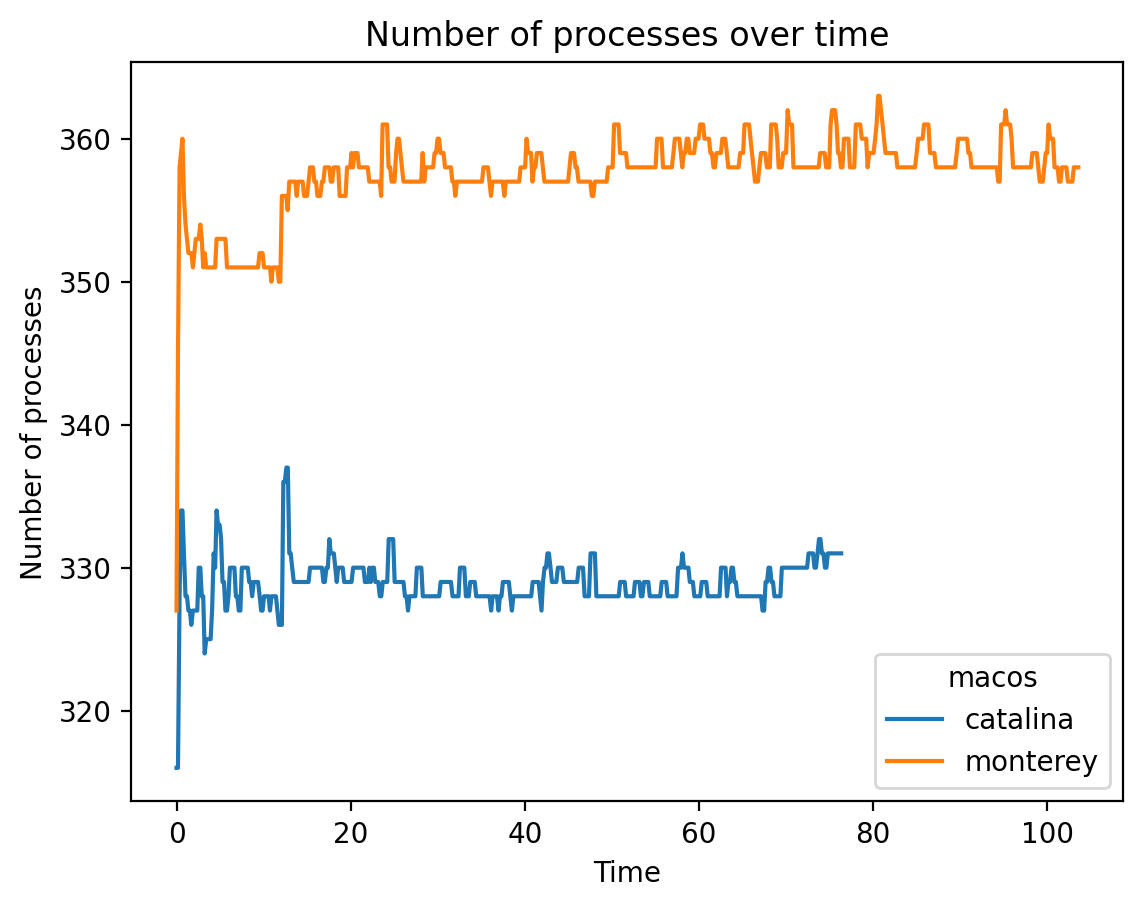

In [108]:
sns.lineplot(data=proc_count, x="delta", y="pid_count", hue="macos", )
plt.title("Number of processes over time")
plt.xlabel("Time");
plt.ylabel("Number of processes");

In [109]:
stat_df = pd.concat([cat_stat_df.assign(macos="catalina"), mon_stat_df.assign(macos="monterey")])
stat_df.head()

keys,cpu_temp,total_fans_in_system,fan_0_speed,fan_1_speed,cycle_count,max_cycles,current_charge,maximum_charge,design_capacity,battery_temp,date,process,delta_time,delta,macos
0,32.63,2.0,1841.0,1705.0,182.0,1000.0,4363.0,7767.0,8790.0,30.50,2023-01-26 15:42:57-03:00,istats,0 days 00:00:00,0.000000,catalina
1,34.19,2.0,1822.0,1705.0,182.0,1000.0,4363.0,7767.0,8790.0,30.50,2023-01-26 15:43:07-03:00,istats,0 days 00:00:10,0.166667,catalina
2,36.44,2.0,1843.0,1697.0,182.0,1000.0,4363.0,7767.0,8790.0,30.59,2023-01-26 15:43:18-03:00,istats,0 days 00:00:21,0.350000,catalina
3,39.00,2.0,1835.0,1705.0,182.0,1000.0,4363.0,7767.0,8790.0,30.69,2023-01-26 15:43:28-03:00,istats,0 days 00:00:31,0.516667,catalina
4,40.38,2.0,1828.0,1699.0,182.0,1000.0,4279.0,7705.0,8790.0,30.80,2023-01-26 15:43:38-03:00,istats,0 days 00:00:41,0.683333,catalina


<AxesSubplot: xlabel='delta', ylabel='cpu_temp'>

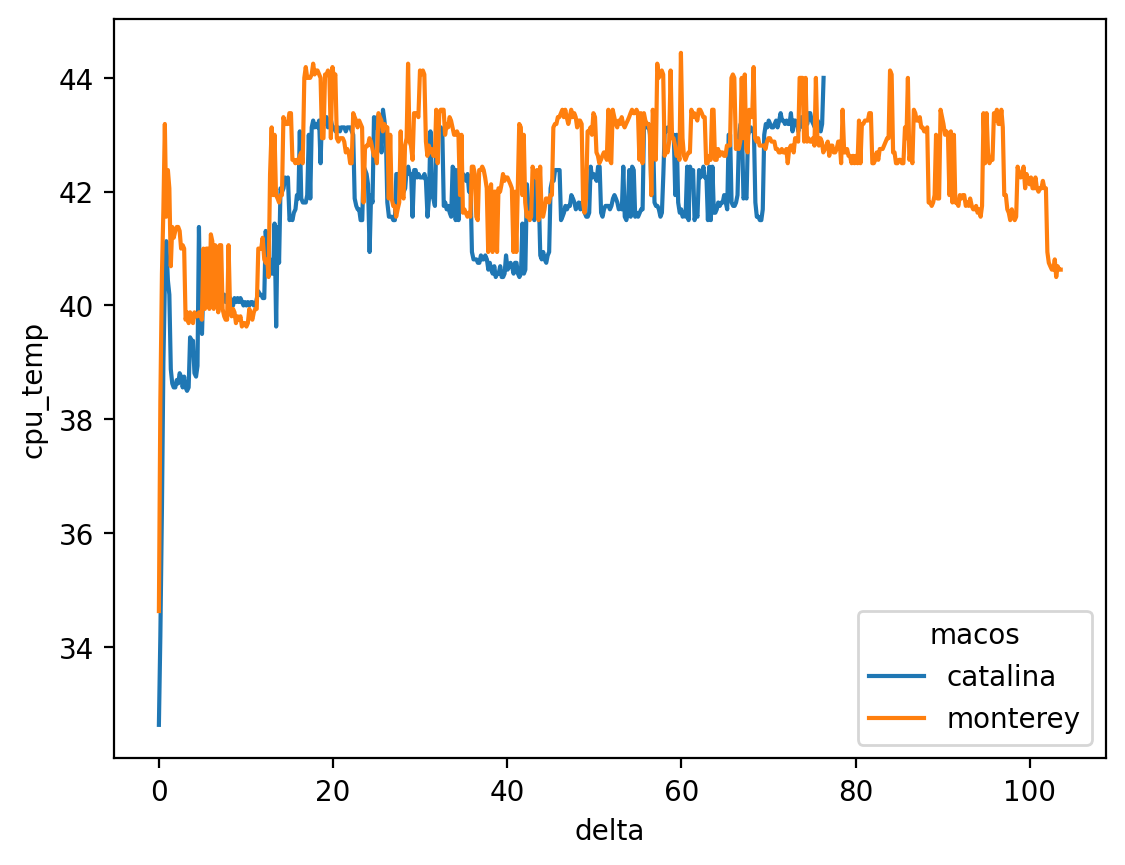

In [110]:
sns.lineplot(data=stat_df, x="delta", y="cpu_temp", hue="macos")

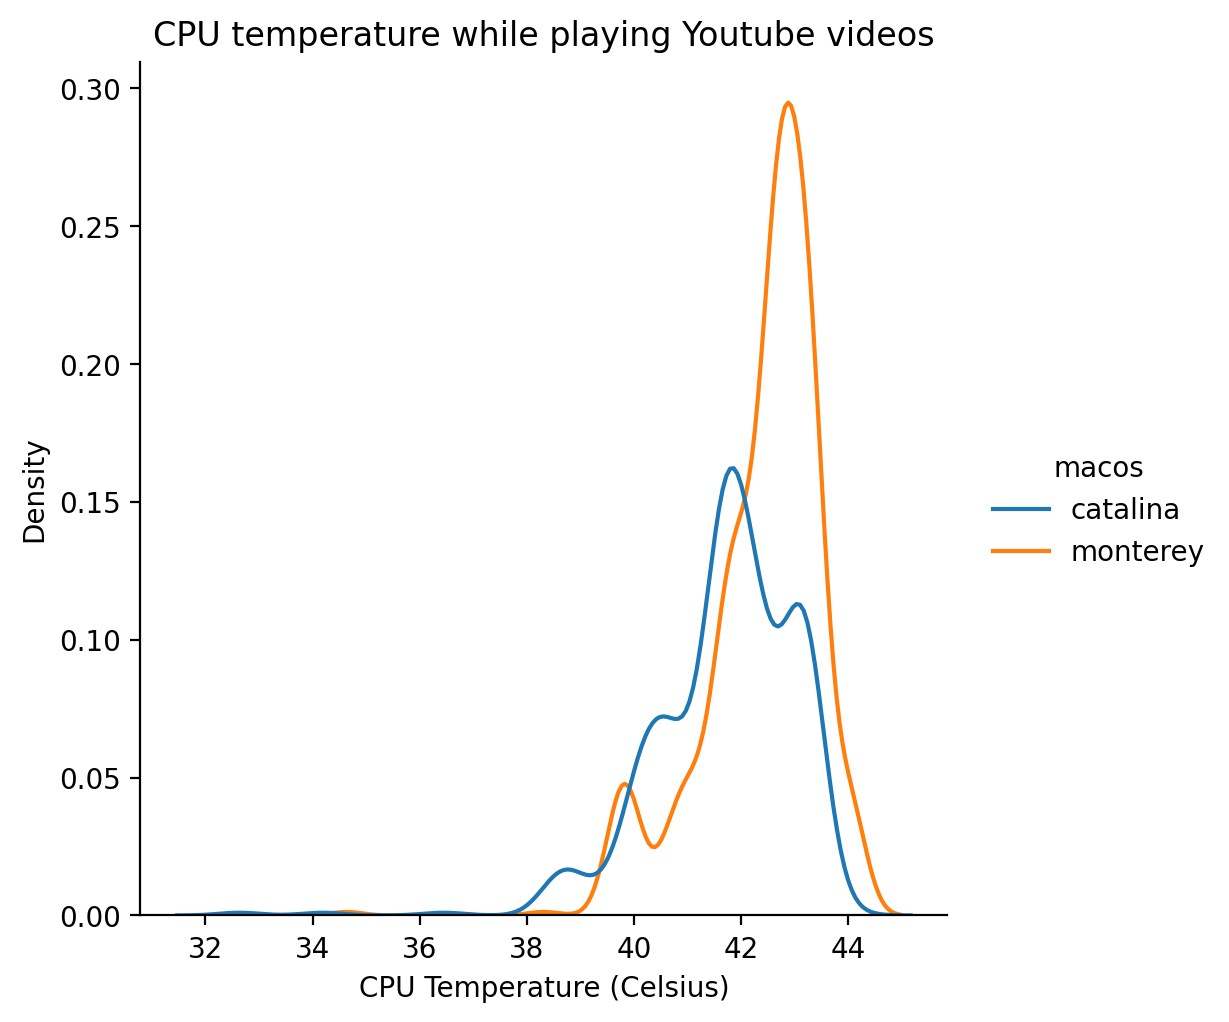

In [111]:
cutout = stat_df['cpu_temp'].quantile(0.99)
sns.displot(data=stat_df[stat_df['cpu_temp'] < cutout], x="cpu_temp", hue="macos", kind="kde")
plt.title("CPU temperature while playing Youtube videos")
plt.xlabel("CPU Temperature (Celsius)");

In [59]:
proc_df.to_csv(OUTPUT_PROC, index=False, compression="gzip")

In [61]:
stat_df.to_csv(OUTPUT_STAT, index=False, compression="gzip")